In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import baqcs
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister

In [4]:
def create_parametrized_circuit(theta_a=0.5, phi_a=0.3, theta_s0=1.0, phi_s1=0.7):
    """
    Create a parametrized quantum circuit with mid-circuit measurement.
    
    Parameters control the rotation angles and conditional operations.
    """
  # create registers
    sys_qubits = QuantumRegister(2, 'sys')
    anc_qubit = AncillaRegister(1, 'anc')
    sys_clbits = ClassicalRegister(2, 'sys_meas')
    anc_clbit = ClassicalRegister(1, 'anc_meas')
    
  # create circuit
    qc = QuantumCircuit(sys_qubits, anc_qubit, sys_clbits, anc_clbit)
    
  # initialize with uniform superposition (H gates on all qubits)
    qc.h(sys_qubits[0])
    qc.h(sys_qubits[1])
    qc.h(anc_qubit[0])
    
  # entangle ancilla with system qubits
    qc.cx(anc_qubit[0], sys_qubits[0])
    qc.cx(anc_qubit[0], sys_qubits[1])
    
  # apply some rotations on the ancilla
    qc.ry(theta_a * np.pi, anc_qubit[0])
    qc.rz(phi_a * np.pi, anc_qubit[0])
    
  # mid-circuit measurement on ancilla
    qc.measure(anc_qubit[0], anc_clbit[0])
    
  # Conditional operations based on ancilla measurement
    with qc.if_test((anc_clbit[0], 1)) as else_:
      # ancilla measured as 1
        qc.x(sys_qubits[0])
        qc.ry(theta_s0 * np.pi, sys_qubits[0])
        qc.cz(sys_qubits[0], sys_qubits[1])

    with else_:
      # ancilla measured as 0
        qc.rz(phi_s1 * np.pi, sys_qubits[1])
        qc.cx(sys_qubits[0], sys_qubits[1])
    
  # final measurement on system qubits
    qc.measure(sys_qubits, sys_clbits)
    
    return qc

In [5]:
sampler = baqcs.Sampler()

In [6]:
# Create a parametrized circuit
# Adjust these parameters to create different ancilla distributions
circuit = create_parametrized_circuit(
    theta_a=0.3,  # Theta rotation on ancilla
    phi_a=0.5,    # Phi rotation on ancilla
    theta_s0=0.8, # Conditional rotation on 1st system qubit
    phi_s1=0.6    # Conditional rotation on 2nd system qubit
)

In [7]:
sys_counts, anc_counts, counts = sampler.sample(circuit)

In [8]:
base_circuit, zero_circuit, one_circuit = baqcs.decompose(circuit)

In [9]:
session = baqcs.Session()
cpt = session.estimate_p([0, 1],
         base_circuit, (zero_circuit, one_circuit))
print(cpt)

tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.1031, 0.3969, 0.1031, 0.3969]])


In [10]:
from baqcs.models import binomial_ancilla_model

In [11]:
result = session.run_mcmc_inference(binomial_ancilla_model, sys_counts, cpt)

Sample: 100%|███████████████████████████████████████| 2500/2500 [00:07, 338.16it/s, step size=1.20e+00, acc. prob=0.907]                                                          


In [12]:
def analyze_results(samples, ancilla_outcomes):
    """
    Analyze and visualize the inference results.
    """
  # extract the inferred probability of ancilla being 1
    p_ancilla_one_samples = samples["p_ancilla_one"].numpy()
    
  # "true" probability (as sampled)
    try:
        true_p = ancilla_outcomes['1']/sum(ancilla_outcomes.values())
    except KeyError:
        true_p = np.mean(ancilla_outcomes)
    
  # plot posterior distribution
    plt.figure(figsize=(10, 6))
    plt.hist(p_ancilla_one_samples, bins=50, density=True, alpha=0.7, 
             label='Posterior distribution')
    plt.axvline(true_p, color='red', linestyle='--', linewidth=2, 
                label=f'True probability: {true_p:.3f}')
    plt.axvline(np.mean(p_ancilla_one_samples), color='green', linestyle='--', 
                linewidth=2, label=f'Posterior mean: {np.mean(p_ancilla_one_samples):.3f}')
    plt.xlabel('P(Ancilla = 1)')
    plt.ylabel('Density')
    plt.title('Posterior Distribution of Ancilla Measurement Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
  # print summary statistics
    print(f"True P(Ancilla = 1): {true_p:.4f}")
    print(f"Posterior mean: {np.mean(p_ancilla_one_samples):.4f}")
    print(f"Posterior std: {np.std(p_ancilla_one_samples):.4f}")
    print(f"95% Credible interval: [{np.percentile(p_ancilla_one_samples, 2.5):.4f}, "
          f"{np.percentile(p_ancilla_one_samples, 97.5):.4f}]")

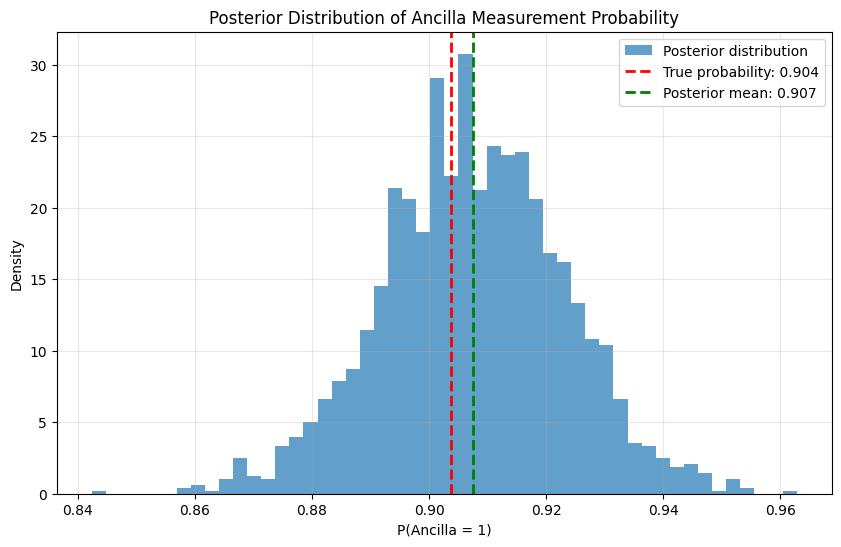

True P(Ancilla = 1): 0.9037
Posterior mean: 0.9075
Posterior std: 0.0156
95% Credible interval: [0.8761, 0.9384]


In [13]:
analyze_results(result, anc_counts)

In [14]:
from baqcs.models import generic_ancilla_model_with_circuit
from baqcs.guides import logit_guide

In [15]:
def generic_ancilla_model(observations=None):
    return generic_ancilla_model_with_circuit(
        probability_table = cpt,
        observations = observations)

In [16]:
# explore all possible outcomes
Ns = len(circuit.qubits) - len(circuit.ancillas)

results = dict()
for observation in range(Ns**2):
    print(f"\nObservation: {observation} (binary: {format(observation, '02b')})")
    observations = torch.tensor([observation])
    final_probs = session.svi(
        sys_qubits = range(Ns),
        model = generic_ancilla_model,
        guide = logit_guide,
        observations = observations,
        seed=42,
    )

    results[observations] = final_probs

    print("-" * 50)
    print(f"Final P(ancilla=0|observations): {final_probs[0]:.4f}")
    print(f"Final P(ancilla=1|observations): {final_probs[1]:.4f}")


Observation: 0 (binary: 00)
Step    0, Loss:   1.8294, P(ancilla=1): 0.4950
--------------------------------------------------
Final P(ancilla=0|observations): 0.7228
Final P(ancilla=1|observations): 0.2772

Observation: 1 (binary: 01)
Step    0, Loss:   1.1551, P(ancilla=1): 0.5050
--------------------------------------------------
Final P(ancilla=0|observations): 0.3923
Final P(ancilla=1|observations): 0.6077

Observation: 2 (binary: 10)
Step    0, Loss:   1.8294, P(ancilla=1): 0.4950
--------------------------------------------------
Final P(ancilla=0|observations): 0.7228
Final P(ancilla=1|observations): 0.2772

Observation: 3 (binary: 11)
Step    0, Loss:   1.1551, P(ancilla=1): 0.5050
--------------------------------------------------
Final P(ancilla=0|observations): 0.3923
Final P(ancilla=1|observations): 0.6077


In [17]:
# find the answer based on combining the system measurements
prob_0, prob_1 = 0, 0
for obs, probs in results.items():
    outcome = format(obs[0], f'0{Ns}b')
    cnt = sys_counts[outcome[::-1]]
    prob_0 += cnt*probs[0]
    prob_1 += cnt*probs[1]

n_meas = sum(sys_counts.values())
print("est. P(ancilla=0):", prob_0/n_meas)
print("est. P(ancilla=1):", prob_1/n_meas)

est. P(ancilla=0): tensor(0.4695)
est. P(ancilla=1): tensor(0.5305)


In [18]:
# full SVI
Ns = len(circuit.qubits) - len(circuit.ancillas)

final_probs = session.svi(
    sys_qubits = range(Ns),
    model = generic_ancilla_model,
    guide = logit_guide,
    observations = sys_counts,
    seed=42,
)

print("-" * 50)
print(f"Final P(ancilla=0|observations): {final_probs[0]:.4f}")
print(f"Final P(ancilla=1|observations): {final_probs[1]:.4f}")

Step    0, Loss: 10752.6660, P(ancilla=1): 0.5050
--------------------------------------------------
Final P(ancilla=0|observations): 0.4611
Final P(ancilla=1|observations): 0.5389


In [19]:
# actual probabilities based on the data
print("data P(ancilla=0):", anc_counts['0']/sum(anc_counts.values()))
print("data P(ancilla=1):", anc_counts['1']/sum(anc_counts.values()))

data P(ancilla=0): 0.0963134765625
data P(ancilla=1): 0.9036865234375
